## CIFAR Code - Mobile_net architecture

#####The CIFAR-10 dataset is similar to MNIST, except that instead of one color channel (grayscale) there are three channels (RGB).Where an MNIST image has a size of (1,28,28), CIFAR images are (3,32,32). There are 10 categories an image may fall under:

0. airplane
1. automobile
2. bird
3. cat
4. deer
5. dog
6. frog
7. horse
8. ship
9. truck

In [0]:
# importing the useful libraries
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchvision import models
from torchsummary import summary
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torchvision
import os
import sys
import time
import math
import datetime as dt
import tqdm
import argparse
import glob
import matplotlib.pyplot as plt
import tarfile
import warnings 
import torch.optim as optim
import torch.utils.data
warnings.filterwarnings("ignore")



### Importing the  CIFAR-10 dataset


In [2]:
from PIL import Image
from keras.datasets import cifar10

Using TensorFlow backend.


### Let us view some images from the dataset

170500096/170498071 [==============================] - 4s 0us/step


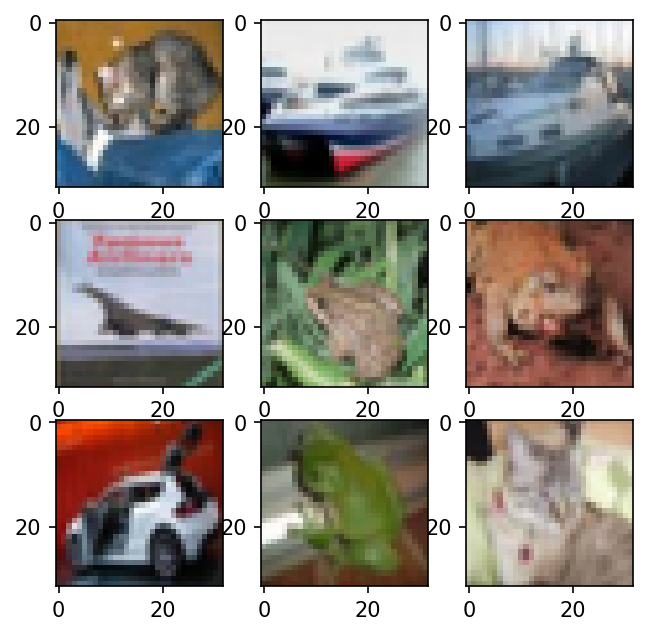

In [3]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(5, 5), dpi=150, facecolor='w', edgecolor='k')

def show_imgs(X):
    plt.figure(1)
    k = 0
    for i in range(0,3):
        for j in range(0,3):
            plt.subplot2grid((3,3),(i,j))
            plt.imshow(Image.fromarray(X[k]))
            k = k+1
    # show the plot
    plt.show()
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:9])

### Augmentations on the datset images

In [0]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    #transforms.ColorJitter(brightness=1, contrast=0, saturation=0, hue=0),
    #transforms.RandomRotation(degrees=[-12,12], resample=False, expand=False, center=None, fill=0),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

### Loading the Train and Test dataset

In [5]:
# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                            transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor()
                                            )

Extracting ../../data/cifar-10-python.tar.gz to ../../data/


In [0]:

#defining the batch size.
batch_size = 64


### Creating Loaders

In [0]:

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Visualizing images after augmentation

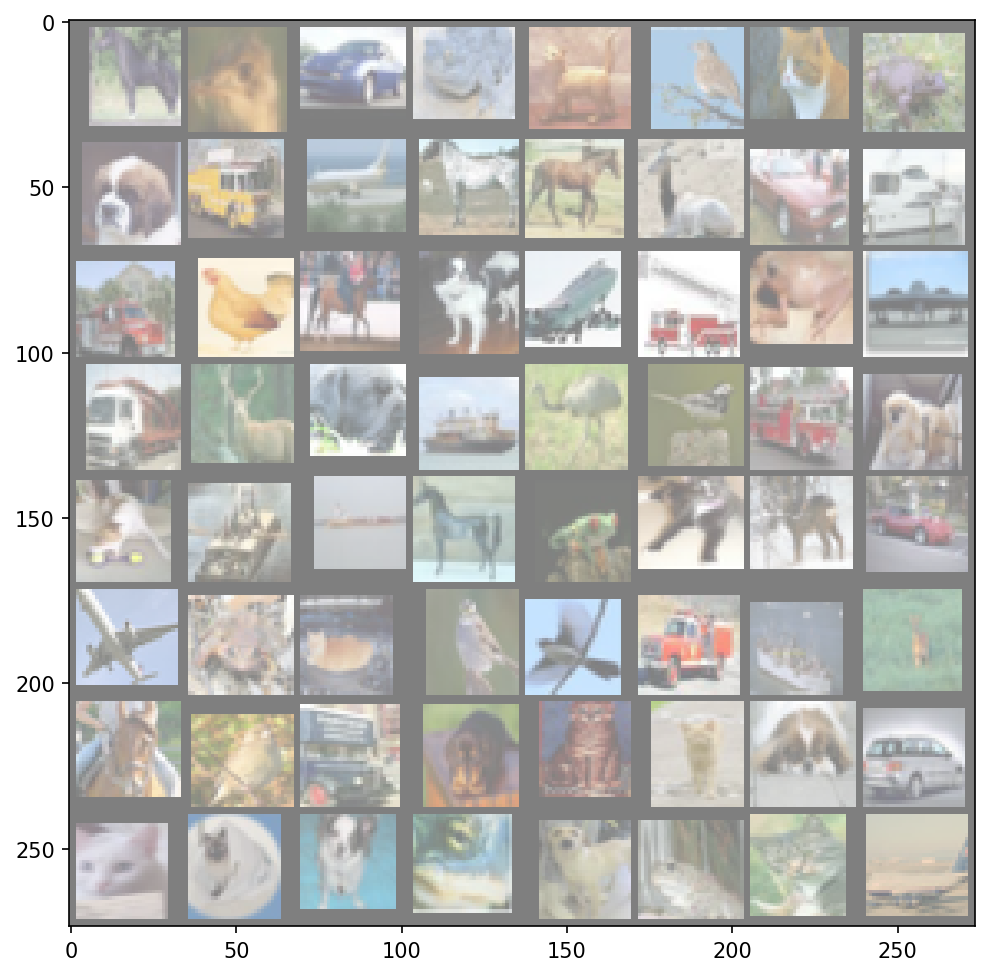

horse  bird   car  frog   cat


In [8]:
# functions to show an image

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 8), dpi=150, facecolor='w', edgecolor='k')
# functions to show an image
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

### Mobile Net block

In [0]:
class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

### The Mobile Net architecture

In [0]:
class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512,512, (1024,2), 1024]  #change the depth of convolution.(Removed 3X512)

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

net = MobileNet()
  

In [0]:
#setting the model on cuda
net = MobileNet(num_classes=10)
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    net.cuda()
#net

### Defining optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4,nesterov=True)

### Train and test functions

In [0]:
def train_net():
    net.train()
    train_loss = 0
    n_correct = 0
    n_total = 0
    for batch_size, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        n_correct += predicted.eq(targets).sum().item()
        n_total += targets.shape[0]
    return train_loss/(batch_size+1),n_correct/n_total

def get_loss_acc(is_test_dataset = True):
    net.eval()
    dataloader = test_loader if is_test_dataset else train_loader
    n_correct = 0
    n_total = 0
    test_loss = 0
    with torch.no_grad():
        for batch_size, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = net(inputs)
            test_loss += criterion(outputs, targets).item()
            _, predicted = outputs.max(1)
            n_correct += predicted.eq(targets).sum().item()
            n_total += targets.shape[0]
    return test_loss/(batch_size+1),n_correct/n_total

In [15]:
EPOCH = 80
start = dt.datetime.now()
start_epoch=0
for epochi in range(start_epoch,start_epoch + EPOCH):
    #scheduler.step()
    cur_lr = [i['lr'] for i in optimizer.param_groups][0]
    print("Btach Size",batch_size,'(%.2fs)\n\nEpoch: %d/%d | cur_lr:%.4f ' % (
       (dt.datetime.now()-start).seconds, epochi+1,EPOCH+start_epoch,cur_lr))
    start = dt.datetime.now()
    

    test_loss , test_acc = get_loss_acc()
    train_loss , train_acc = train_net()
    #hist.append([train_loss , train_acc,test_loss , test_acc])
    print( 'train Loss: %.3f | Acc: %.3f%% \ntest Loss: %.3f | Acc: %.3f%% ' % (
        train_loss, train_acc*100,test_loss, test_acc*100))
    

    

Btach Size 64 (0.00s)

Epoch: 1/80 | cur_lr:0.0100 
train Loss: 1.698 | Acc: 37.118% 
test Loss: 2.303 | Acc: 10.000% 
Btach Size 64 (28.00s)

Epoch: 2/80 | cur_lr:0.0100 
train Loss: 1.303 | Acc: 53.038% 
test Loss: 1.436 | Acc: 48.170% 
Btach Size 64 (28.00s)

Epoch: 3/80 | cur_lr:0.0100 
train Loss: 1.086 | Acc: 61.342% 
test Loss: 1.208 | Acc: 58.060% 
Btach Size 64 (27.00s)

Epoch: 4/80 | cur_lr:0.0100 
train Loss: 0.929 | Acc: 67.060% 
test Loss: 1.001 | Acc: 64.690% 
Btach Size 64 (28.00s)

Epoch: 5/80 | cur_lr:0.0100 
train Loss: 0.816 | Acc: 71.264% 
test Loss: 0.847 | Acc: 69.950% 
Btach Size 64 (28.00s)

Epoch: 6/80 | cur_lr:0.0100 
train Loss: 0.738 | Acc: 74.094% 
test Loss: 0.753 | Acc: 73.510% 
Btach Size 64 (28.00s)

Epoch: 7/80 | cur_lr:0.0100 
train Loss: 0.667 | Acc: 76.598% 
test Loss: 0.693 | Acc: 75.920% 
Btach Size 64 (28.00s)

Epoch: 8/80 | cur_lr:0.0100 
train Loss: 0.621 | Acc: 78.512% 
test Loss: 0.644 | Acc: 77.550% 
Btach Size 64 (28.00s)

Epoch: 9/80 | cur

### Counting the number of parameters in model

In [0]:
def count_parameters(model):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    print("Total_params",pytorch_total_params)
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable_params",pytorch_total_params)

In [19]:
count_parameters(net)

Total_params 2410826
Trainable_params 2410826


In [24]:
total_correct = 0
total_images = 0
confusion_matrix = np.zeros([10,10], int)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()
        for i, l in enumerate(labels):
            confusion_matrix[l.item(), predicted[i].item()] += 1 

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

Model accuracy on 10000 test images: 84.47%


### Checking accuracy for each class

In [25]:
print('{0:10s} - {1}'.format('Category','Accuracy'))
for i, r in enumerate(confusion_matrix):
    print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

Category   - Accuracy
plane      - 82.9
car        - 86.0
bird       - 82.1
cat        - 70.0
deer       - 84.0
dog        - 79.5
frog       - 85.6
horse      - 90.1
ship       - 93.4
truck      - 91.1


### Visualizing the prediction accuracy

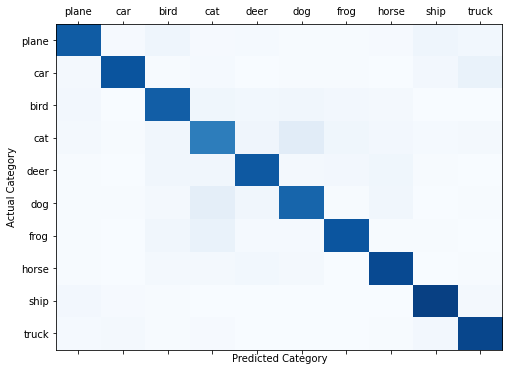

In [26]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()